# Preparations

In [ ]:
!pip install prophet
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from prophet.make_holidays import make_holidays_df

Mounted at /content/drive


In [ ]:
# Load training and test data
train = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/overall/divvy_train.csv")
test = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/prod/overall/divvy_test.csv")
rides_citywide = pd.concat([train, test])

In [ ]:
rides_citywide.head()

,date,total_rides,stations_shift,stations_ma365,stations_ma30,ebike_shift,ebike_shift_proportion,ebike_proportion_ma365,ebike_proportion_ma30,temp_min_c,rain_sum_mm,snowfall_sum_cm,month,dayofweek,year
0,2020-01-01,2141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.5,0.0,0.00,1,2,2020
1,2020-01-02,6479,405.0,405.000000,405.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.00,1,3,2020
2,2020-01-03,5890,500.0,452.500000,452.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1,4,2020
3,2020-01-04,3187,482.0,462.333333,462.333333,0.0,0.0,0.0,0.0,-3.5,0.2,0.42,1,5,2020
4,2020-01-05,3035,433.0,455.000000,455.000000,0.0,0.0,0.0,0.0,-4.1,0.0,0.00,1,6,2020


# Helper Functions

In [ ]:
def preprocess_tree_models_citywide(rides_citywide):
  df = rides_citywide.copy()

  # Convert date column to datetime
  df['date'] = pd.to_datetime(df['date'])

  # Historical Rides
  lags_columns = []
  for lag in [1, 7, 30, 90, 365]:
    df[f'y_lag{lag}'] = df['total_rides'].shift(lag)
    lags_columns.append(f'y_lag{lag}')

  # Time Variables
  df['year'] = df['year']-2020
  df = pd.get_dummies(df, columns=['month'], prefix='month')
  df['week_of_year'] = df["date"].dt.isocalendar().week
  df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
  df = pd.get_dummies(df, columns=['dayofweek'], prefix='dayofweek')
  time_columns = ['year', 'week_of_year', 'is_weekend'] \
   + [f"month_{i}" for i in range(1,13)] \
    + [f"dayofweek_{i}" for i in range(7)]

  # Weather
  quantiles_train = df[(df["date"]<"2024-01-01") & (df['rain_sum_mm']>0)]['rain_sum_mm'].quantile([0.5])
  q = quantiles_train.values[0]
  print(f"Rain Boundary:{q}")
  bins = [-np.inf, 0, q, np.inf]  # Include -inf and inf to cover all ranges
  df['rainfall_level'] = pd.cut(df['rain_sum_mm'], bins=bins, labels=["no", "moderate", "heavy"])
  df = pd.get_dummies(df, columns=['rainfall_level'], prefix='rainfall_level')

  df['snowfall_flag'] = (df['snowfall_sum_cm'] > 0).astype(int)

  weather_columns = ["temp_min_c","snowfall_flag"] \
   + [f"rainfall_level_{i}" for i in ["no", "moderate", "heavy"]]

  # Holiday
  holidays = make_holidays_df(list(range(2021,2026)),"US")
  df = pd.merge(left=df, right=holidays,how="left",left_on="date",right_on="ds")
  df["holiday_binary"] = df["holiday"].notna().astype(int)

  # Price
  divvy_pricing_history = pd.DataFrame({
    "date": ["2019-07-01", "2022-05-10", "2023-03-29", "2024-02-05"],
    "Annual Membership": [108, 119, 130.9, 143.9],
    "Day Pass": [15, 16.5, 16.5, 18.1],
    "Unlock Fee exists": [0, 1, 1, 1],
    "Member ebike Unlock Fee exists": [0, 1, 0, 0],
  })
  divvy_pricing_history["date"] = pd.to_datetime(divvy_pricing_history["date"])
  df = pd.merge_asof(
    df,
    divvy_pricing_history,
    on='date',
    direction='backward'
  )
  price_columns = divvy_pricing_history.columns.tolist()
  price_columns.remove("date")

  # Supply Side
  supply_columns = ["stations_ma365", "ebike_proportion_ma365"]

  # Selected Columns
  df.set_index("date", inplace=True)
  selected_columns = ["total_rides"] \
   + lags_columns \
    + time_columns \
     + weather_columns \
      + ["holiday_binary"] \
       + supply_columns \
        + price_columns
  df = df[selected_columns].astype(float)
  df.reset_index(inplace=True)



  df = df[df["date"]>= "2021-01-01"]
  df.dropna(inplace=True)
  return df

def train_test_split_by_date(df, split_date="2024-01-01"):
  data_raw = df.copy()
  train = data_raw[data_raw.index < split_date]
  test = data_raw[(data_raw.index >= split_date) & (data_raw.index < "2025-01-01")]
  return train, test

def error_metrics(real, pred): # Compare predictions and real values
  mae = mean_absolute_error(real, pred)
  mse = mean_squared_error(real, pred)
  mape = mean_absolute_percentage_error(real, pred)
  smape = mean_absolute_percentage_error(real, pred, symmetric=True)
  r2 = r2_score(real, pred)  # Calculate R-squared

  # Print results
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Squared Error (MSE): {mse:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
  print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape*100:.2f}%")
  print(f"R-squared (R²): {r2:.4f}")  # Display R-squared

# Modelling

## XgBoost

### Feature Engineer & Train Test Split

In [ ]:
rides_citywide_model = preprocess_tree_models_citywide(rides_citywide)
rides_citywide_model.set_index("date", inplace=True)
train, test = train_test_split_by_date(rides_citywide_model)
x_train = train.drop(columns=['total_rides'])
y_train = train['total_rides']
x_test = test.drop(columns=['total_rides'])
y_test = test['total_rides']
train.head()

Rain Boundary:2.5


,total_rides,y_lag1,y_lag7,y_lag30,y_lag90,y_lag365,year,week_of_year,is_weekend,month_1,...,rainfall_level_no,rainfall_level_moderate,rainfall_level_heavy,holiday_binary,stations_ma365,ebike_proportion_ma365,Annual Membership,Day Pass,Unlock Fee exists,Member ebike Unlock Fee exists
date,,,,,,,,,,,,,,,,,,,,,
2021-01-02,2275.0,1068.0,2409.0,5421.0,12875.0,2141.0,1.0,53.0,1.0,1.0,...,1.0,0.0,0.0,0.0,503.810959,0.130885,108.0,15.0,0.0,0.0
2021-01-03,2383.0,2275.0,3498.0,6126.0,12533.0,6479.0,1.0,53.0,1.0,1.0,...,0.0,1.0,0.0,0.0,503.860274,0.131732,108.0,15.0,0.0,0.0
2021-01-04,3209.0,2383.0,3657.0,6059.0,16126.0,5890.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,503.638356,0.132584,108.0,15.0,0.0,0.0
2021-01-05,3845.0,3209.0,2655.0,4278.0,17471.0,3187.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,503.558904,0.133522,108.0,15.0,0.0,0.0
2021-01-06,3884.0,3845.0,1850.0,4685.0,16519.0,3035.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,503.632877,0.134426,108.0,15.0,0.0,0.0


### Grid search & Model fiting

In [ ]:
xgb_reg = XGBRegressor(tree_method='hist',device='cuda', random_state=42,verbosity=1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 8, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'alpha': [0.1, 1, 2],  # L1 regularization
    'lambda': [0, 1]   # L2 regularization
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_reg, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 2], 'colsample_bytree': [0.8],
                         'lambda': [0, 1], 'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 8, 10],
                         'n_estimators': [500, 1000, 1500],
                         'subsample': [0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_search.best_params_

{'alpha': 1,
 'colsample_bytree': 0.8,
 'lambda': 1,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 1000,
 'subsample': 0.8}

In [ ]:
# prompt: use best parameter to train and test

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train the model with the best parameters
best_xgb_reg = XGBRegressor(**best_params, tree_method='hist', device='cuda', random_state=42, verbosity=1)
best_xgb_reg.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_reg.predict(x_test)

# Evaluate the model
error_metrics(y_test, y_pred)


Mean Absolute Error (MAE): 1913.14
Mean Squared Error (MSE): 6556504.37
Mean Absolute Percentage Error (MAPE): 19.17%
Symmetric Mean Absolute Percentage Error (sMAPE): 15.85%
R-squared (R²): 0.9117


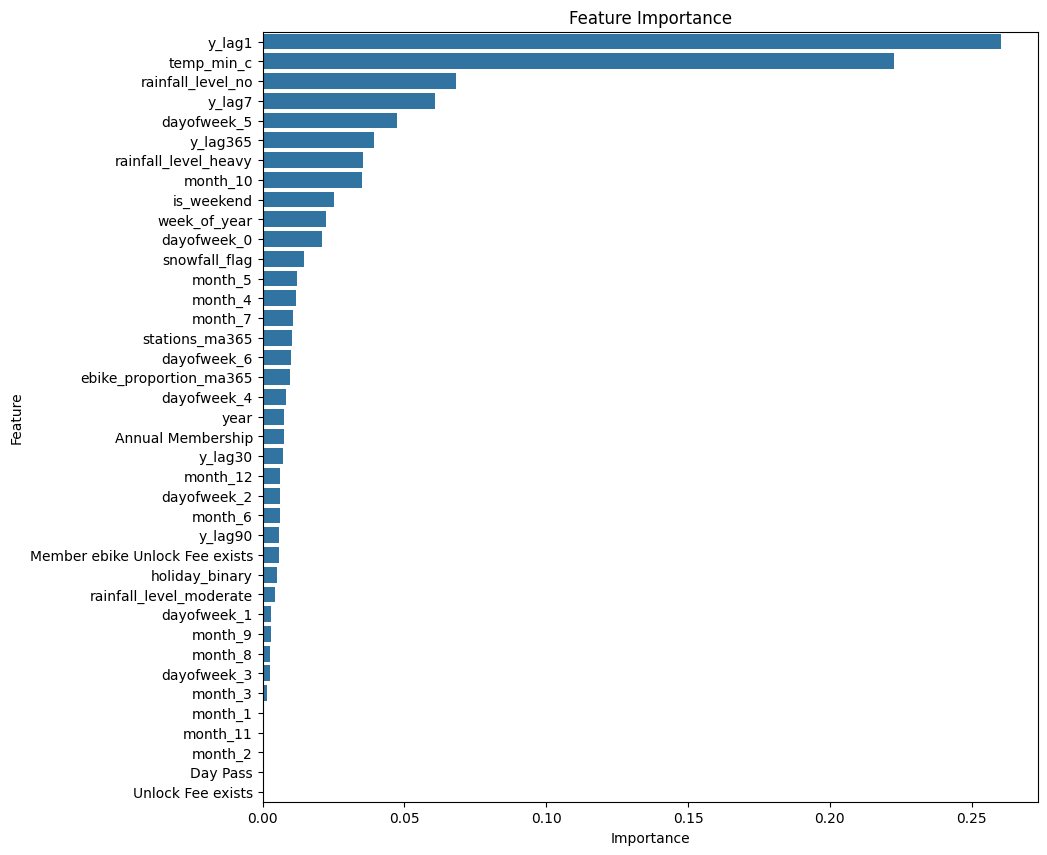

In [ ]:
# prompt: visualize feature importance for loaded model

import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = best_xgb_reg.feature_importances_

# Create a DataFrame for easier visualization
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
# prompt: save model

import joblib

# Save the trained model
joblib.dump(best_xgb_reg, '/content/drive/Shared drives/Time Series/Notebooks/Modeling/modeling_andy/xgb_model_without_cluster.pkl')

# Save the preprocessor (if applicable)
# joblib.dump(preprocessor, 'preprocessor.pkl')


# Example of loading the model later:
# loaded_model = joblib.load('xgb_model.pkl')
# predictions = loaded_model.predict(new_data)


['/content/drive/Shared drives/Time Series/Notebooks/Modeling/modeling_andy/xgb_model_without_cluster.pkl']